In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem


Generate a dataframe of SMC dft dataset

In [4]:
#Preparing to match dft data to ligands we use in smc
#Turing smiles from smc to inchi
df = pd.read_excel('P_selected.xlsx', engine = 'openpyxl', sheet_name='UMAP_origin')
df_all = pd.read_excel('allligands_dft_data_210125.xlsx', engine = 'openpyxl', sheet_name='allligands_dft_data_210125')
#smc_inchi = smc_df['Smiles'].map(Chem.MolFromSmiles).map(Chem.MolToInchi)

In [5]:
df.shape

(161, 207)

Clean up the data
 - clear up non values
 - dropping zero-variance features and similar features

In [6]:
#Arbitrarily assign 0 value to all NaN spaces
df.replace(np.nan, 0)
df = df.sample(frac=1,random_state=42)
#Dropping some of the incomplete/useless parts of dataset
df_origin = df
df_y=df[['ID','x198','Available']]
try:
    df = df.drop(columns = ['SMILES','y1','y2','y3','y4','buch'])
    df = df.drop(columns = ['y6','y10','y11','y12','y13','y14','y17'])
    df = df.drop(columns = ['y15','y16','y18','y19','y5','y7','y8','y9'])
    df = df.drop(columns = ['y1','y2','y11','y12','y13','y14','y16','SMILES','x198'])
except:
    pass
df.to_excel("output.xlsx")  


In [7]:
df=df.drop(columns = ['SMILES','SMC_dataset','x198'])

In [8]:
df.fillna(0)
df=df.drop(columns = ['Available'])

In [9]:
df=df.drop(columns = ['x199','x200','x201','x202','Unnamed: 0'])

In [10]:
# drop highly correlated features
df_corr = df.corr().abs()
upper = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
df = df.drop(to_drop, axis=1)
print (f"Dropping {len(to_drop)} features {to_drop}")

Dropping 47 features ['x7', 'x11', 'x22', 'x35', 'x39', 'x40', 'x41', 'x48', 'x49', 'x63', 'x64', 'x71', 'x72', 'x74', 'x81', 'x82', 'x83', 'x84', 'x85', 'ID.2', 'x89', 'x108', 'x110', 'x111', 'x113', 'x115', 'x119', 'x130', 'x134', 'x135', 'x136', 'x137', 'x138', 'x140', 'x142', 'x145', 'x148', 'x149', 'x150', 'x151', 'x153', 'x155', 'x158', 'x159', 'x177', 'x179', 'x192']


c:\Users\Ran Tao\.conda\envs\edbo\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
df.dropna(axis='columns')
df = df.drop(columns = ['x193','rank'])

UMAP Dimension Reduction to 2

In [21]:
from sklearn.decomposition import PCA
from umap import UMAP
# define the dimensionalities of the reduced representation to study
dims = [ 50, 30, 20, 10, 5, 2]
# dictionary to store data at different levels of dimensionality reduction
dfs={}
# UMAP section
n_neighbors = np.int(np.sqrt(df.shape[1]))
for dim in dims:
    key = f"umap{dim}"
    dfs[key] = pd.DataFrame(UMAP(n_components=dim, n_neighbors=n_neighbors).fit_transform(df), index=df.index)
# PCA section
pc = pd.DataFrame(PCA(n_components=None).fit_transform(df), index=df.index)
for dim in dims:
    key = f"pc{dim}"
    dfs[key] = pc.iloc[:, :dim]

c:\Users\Ran Tao\.conda\envs\edbo\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


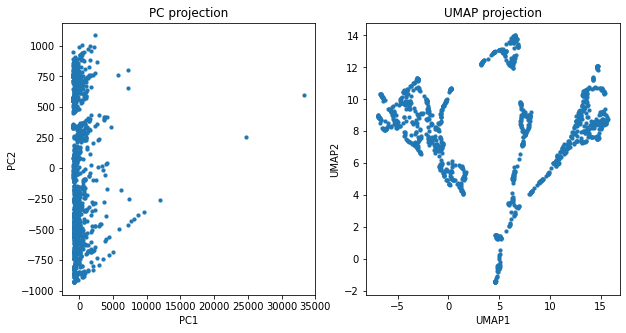

In [ ]:
# Visualize the embeddings
f, ax = plt.subplots(1, 2, figsize=(10, 5)) #, dpi=200)
dfs['pc2'].columns = ['PC1', 'PC2']
dfs['umap2'].columns = ['UMAP1', 'UMAP2']
_= sns.scatterplot(x='PC1', y='PC2', data=dfs['pc2'], s=15, alpha=1, linewidth=0.25,  edgecolor='face', ax=ax[0]).set_title("PC projection")
_=sns.scatterplot(x='UMAP1', y='UMAP2', data=dfs['umap2'], s=15, alpha=1, linewidth=0.25, edgecolor='face', ax=ax[1]).set_title("UMAP projection")

Clustering

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata
from sklearn.metrics import silhouette_score
# Define the numbeor of clusters to study
N_CLS_list = list(range(5, 41))
def silhouette_scores_hierarchical(data, n_cls_list):
 """helper function to compute a silhouette score for hierarchical cluster
ing using Ward linkage"""
 
 z = linkage(data, method='ward')
 
 result = pd.Series(index=n_cls_list, dtype=float)
 for n_cls in n_cls_list:
    cls = fcluster(z, n_cls, criterion='maxclust')
    result.loc[n_cls] = silhouette_score(data, cls)
 return result


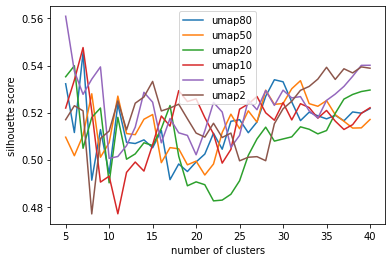

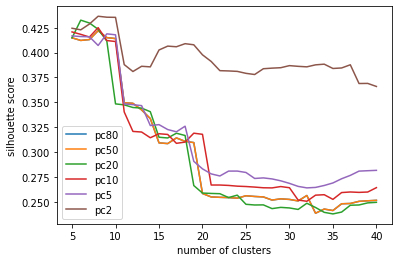

In [ ]:
# populate silhouette scores for all number of clusters and all dimensionality reductions that are pre-calculated
silh_scores = pd.DataFrame(index=N_CLS_list)
for key, value in dfs.items():
    silh_scores[key] = silhouette_scores_hierarchical(value, N_CLS_list)
# plot the silhouette scores
_=silh_scores.groupby(silh_scores.columns.str.startswith('pc'), axis=1).plot(
xlabel='number of clusters',ylabel='silhouette score')


Final Clustering

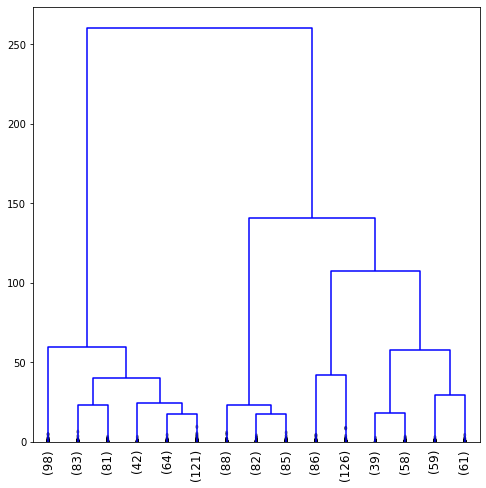

In [ ]:
# final number of clusters to produce
NCLS = 15
# linkage and clustering for selected featurization
z = linkage(dfs['umap10'], method="ward")
cls = fcluster(z, NCLS, criterion='maxclust')
# plot the dendrogram
plt.figure(figsize=(8, 8))
_=dendrogram(z, truncate_mode='lastp', p=NCLS, show_contracted=True, leaf_rotation=90, color_threshold=0)


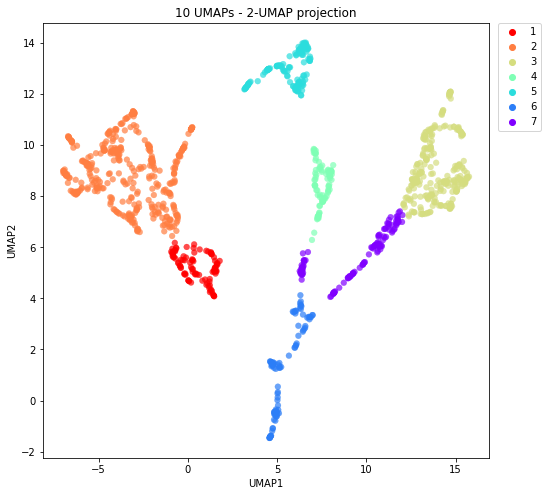

In [ ]:
# plot clustering
NCLS = 7
cls = fcluster(z, NCLS, criterion='maxclust')
plt.figure(figsize=(8, 8))
sns.scatterplot(x="UMAP1", y="UMAP2", data=dfs['umap2'], s=35, alpha=0.7, linewidth=0.25, edgecolor='face',
 palette='rainbow_r', legend='full', hue=cls).set_title("10 UMAPs - 2-UMAP projection")
_=plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)


In [ ]:
df['SMC_dataset']=df_origin['SMC_dataset']
df['Available']=df_origin['Available']

In [ ]:
df.fillna('no')

,ID,x1,x2,x3,x4,x5,x6,x8,x9,x10,...,x186,x187,x188,x189,x190,x191,x192,x193,SMC_dataset,Available
506,1638,-0.046689,1.844566,-0.243832,0.011446,-0.116193,0.255278,0.110155,-0.469041,0.654873,...,6.550213,5.761783,7.733238,1.971455,6.953918,39,41,119.151278,0,no
220,426,-0.045469,1.841348,-0.205811,-0.035296,-0.120553,0.170516,0.051391,-0.366357,1.146582,...,7.297876,7.263432,7.332222,0.068790,7.317809,3,3,87.247694,0,no
1043,389,-0.026179,1.983317,-0.238316,-0.023271,-0.130794,0.215045,0.058258,-0.364497,1.540549,...,6.685183,5.066962,7.514607,2.447645,7.359502,11,28,782.490750,0,no
977,376,-0.025616,1.905466,-0.257267,-0.063555,-0.160411,0.193712,0.021937,-0.421063,0.812445,...,6.941015,6.901608,6.963753,0.062145,6.925532,4,25,944.719472,0,no
174,797,-0.024191,1.900147,-0.256970,-0.079570,-0.168270,0.177400,0.011430,-0.415940,0.811220,...,6.909132,6.909131,6.918910,0.009778,6.918910,3,4,135.847000,0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044,696,-0.042495,1.848350,-0.242774,-0.020463,-0.131619,0.222311,0.073570,-0.388064,1.432730,...,6.996283,5.915757,8.344941,2.429184,8.100306,44,49,1130.571833,0,no
1095,1420,-0.039796,1.880763,-0.239790,-0.044790,-0.142290,0.195000,0.049520,-0.402730,0.803230,...,6.981268,6.981268,6.981268,0.000000,6.981268,1,3,47.696778,0,no
1130,1734,-0.055235,1.801277,-0.229702,0.030832,-0.099435,0.260534,0.114587,-0.404110,0.735237,...,6.707348,5.774025,7.605155,1.831130,7.450455,30,32,353.747472,0,no
860,1018,-0.052241,1.841448,-0.214375,-0.037331,-0.125853,0.177045,0.054434,-0.378555,0.522318,...,6.996854,6.995891,7.616834,0.620943,7.616834,2,10,178.265222,0,no


It makes sense - in cluster 2 there's full of phosphites. I won't expect them to be in the set of 'working ligands'. 

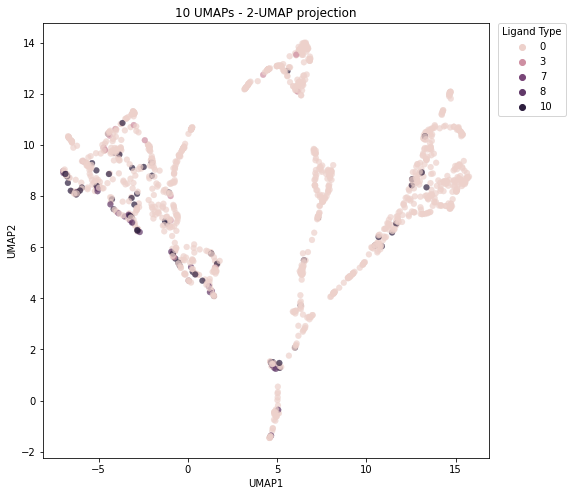

In [ ]:
# plot clustering
NCLS = 7
cls = fcluster(z, NCLS, criterion='maxclust')
plt.figure(figsize=(8, 8))
sns.scatterplot(x="UMAP1", y="UMAP2", data=dfs['umap2'], s=35, alpha=0.7, linewidth=0.25, edgecolor='face',
  legend='full', hue=df['SMC_dataset']).set_title("10 UMAPs - 2-UMAP projection")
_=plt.legend(title='Ligand Type',bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
#,labels=['No','Screened Aromatic', 'Screened Alkyl','Maybe','Priority']


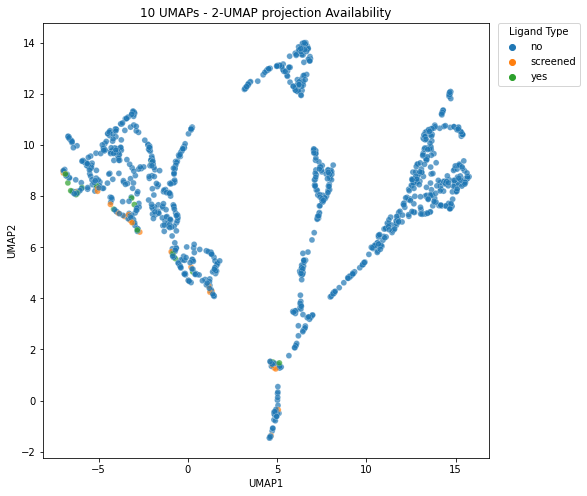

In [ ]:
# plot clustering
NCLS = 7
cls = fcluster(z, NCLS, criterion='maxclust')
plt.figure(figsize=(8, 8))
sns.scatterplot(x="UMAP1", y="UMAP2", data=dfs['umap2'], s=35, alpha=0.7, linewidth=0.25,
  hue=df['Available']).set_title("10 UMAPs - 2-UMAP projection Availability")
_=plt.legend(title='Ligand Type',bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
#,labels=['No','Screened Aromatic', 'Screened Alkyl','Maybe','Priority']

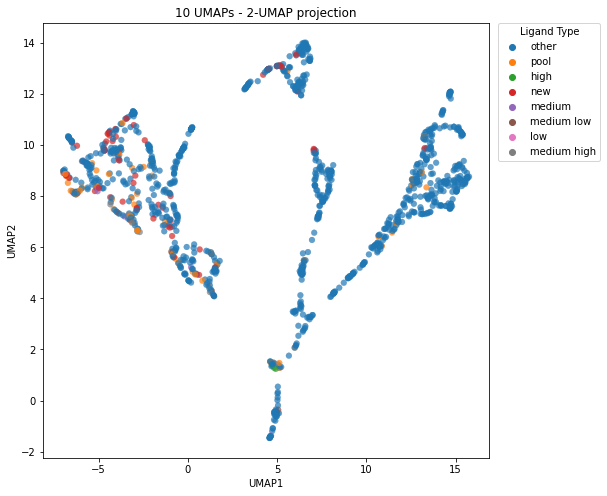

In [ ]:
# plot clustering
NCLS = 7
cls = fcluster(z, NCLS, criterion='maxclust')
plt.figure(figsize=(8, 8))
sns.scatterplot(x="UMAP1", y="UMAP2", data=dfs['umap2'], s=35, alpha=0.7, linewidth=0.25, edgecolor='face',
  legend='full', hue=df_origin['x198']).set_title("10 UMAPs - 2-UMAP projection")
_=plt.legend(title='Ligand Type',bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
#labels=['Probably not','Screened Aromatic', 'Screened Alkyl','Maybe','Priority']

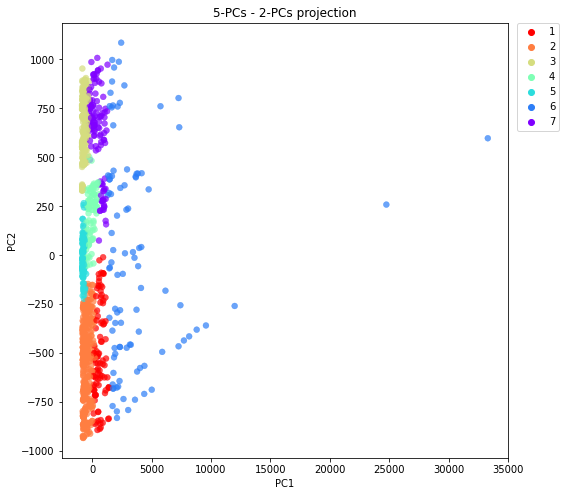

In [ ]:
# plot clustering
NCLS = 7
cls = fcluster(z, NCLS, criterion='maxclust')
plt.figure(figsize=(8, 8))
sns.scatterplot(x="PC1", y="PC2", data=dfs['pc2'], s=35, alpha=0.7, linewidth=0.4, edgecolor='face',
 palette='rainbow_r', legend='full', hue=cls).set_title("5-PCs - 2-PCs projection")
_=plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)

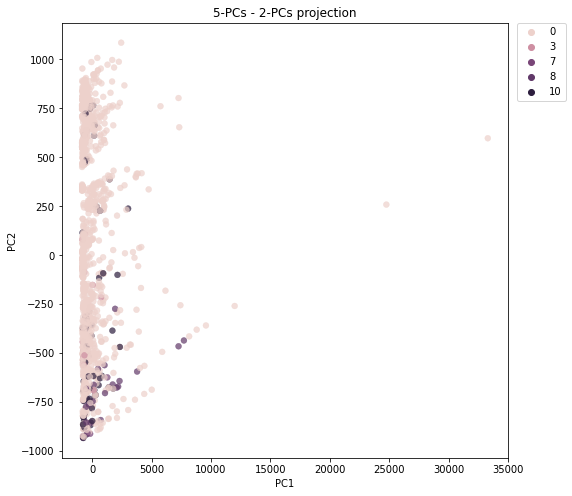

In [ ]:
# plot clustering
NCLS = 7
cls = fcluster(z, NCLS, criterion='maxclust')
plt.figure(figsize=(8, 8))
sns.scatterplot(x="PC1", y="PC2", data=dfs['pc2'], s=35, alpha=0.7, linewidth=0.4, edgecolor='face',
 legend='full', hue=df['SMC_dataset']).set_title("5-PCs - 2-PCs projection")
_=plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)

In [ ]:
def generate_ligand_data(df):
    #Convert the smiles of ligand to a dataframe.
    df = df.copy()
    rxns = []
    smiles = df_origin['SMILES']
    for i in smiles:
        try:
            ligand_smiles = Chem.MolFromSmiles(i)
            rxns.append(ligand_smiles)
        except:
            print(i)
        
    return rxns

Cluster 1, n molecules: 98


[16:39:49] Explicit valence for atom # 7 B, 6, is greater than permitted


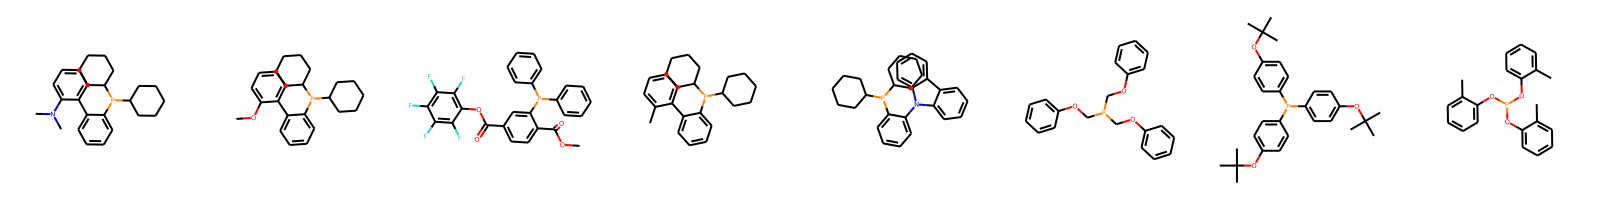

Cluster 2, n molecules: 391


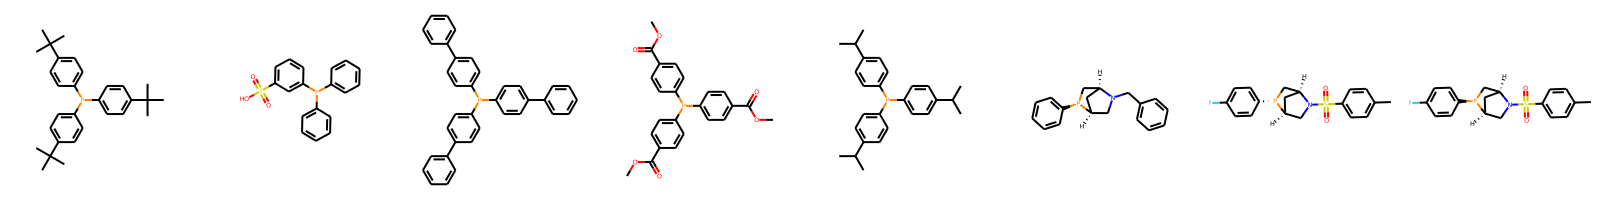

Cluster 3, n molecules: 255


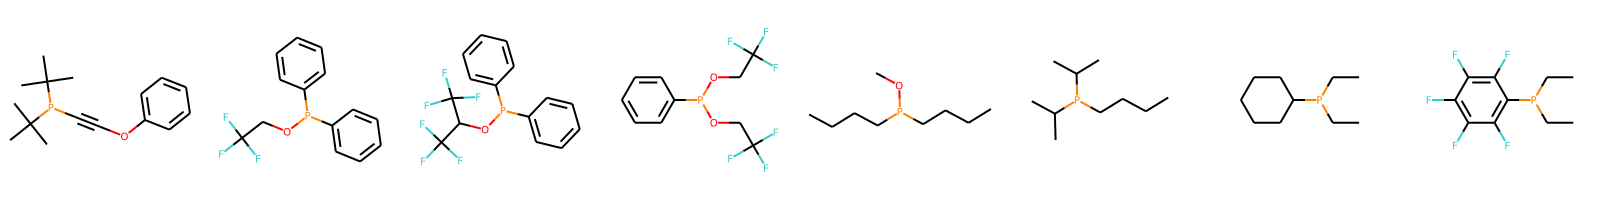

Cluster 4, n molecules: 86


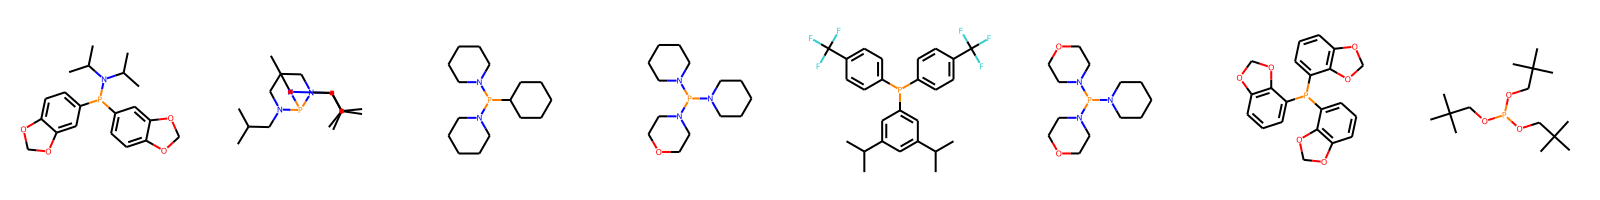

Cluster 5, n molecules: 126


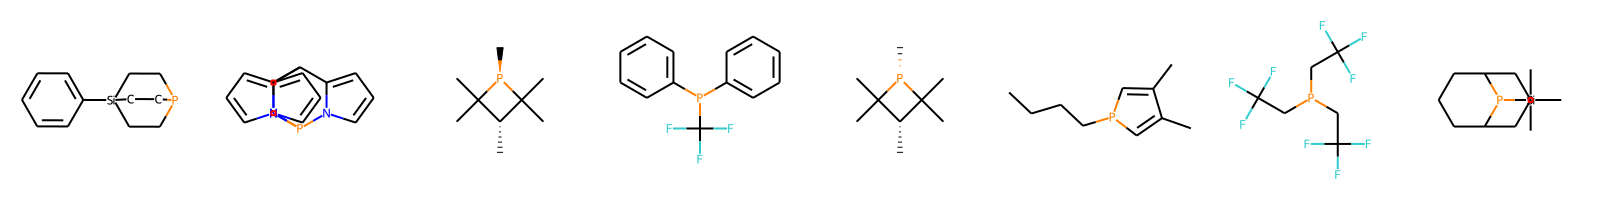

Cluster 6, n molecules: 97


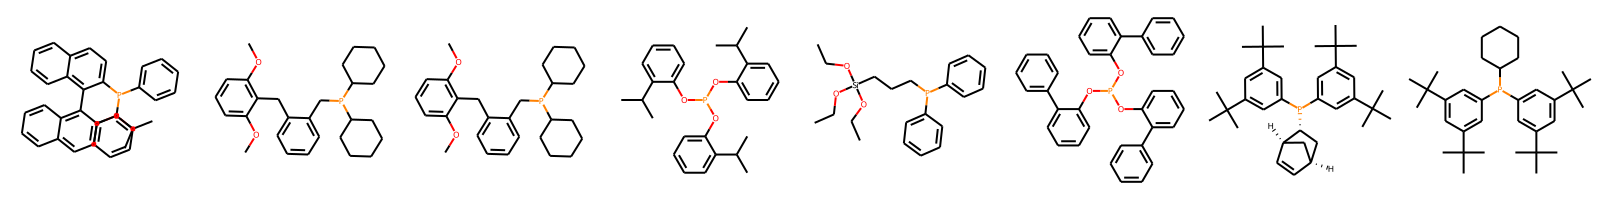

Cluster 7, n molecules: 120


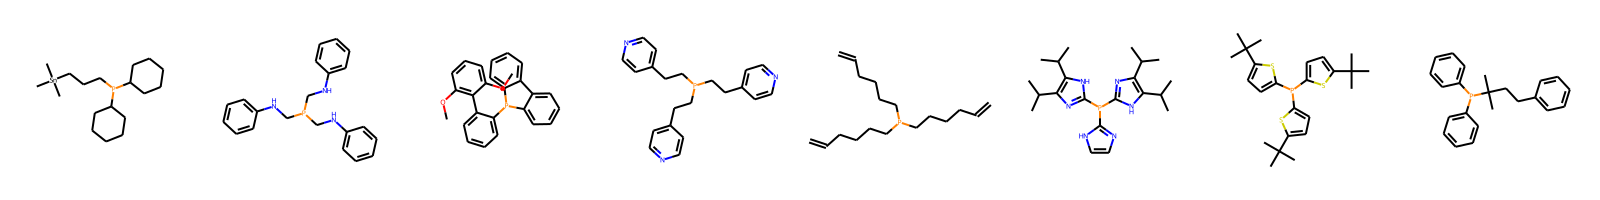

In [ ]:
from scipy.spatial.distance import cdist
from rdkit.Chem import Draw
# build rdkit molecules for all candidates
df = df
df['mol'] = generate_ligand_data(df)
mols = pd.Series(((df['mol'])), index=df.index).to_frame('mol')
features='umap2'
# How many central molecules to display?
n_per_cluster = 8
# store central candidates for 
cands=[]
for group, data in mols.groupby(cls):
 # get descriptor data for this cluster
 desc_data=dfs[features].loc[data.index]
 
 # compute distances of these molecules to their center
 dists=pd.Series(cdist([desc_data.mean()], desc_data)[0],
 index=desc_data.index)
 # select top n central molecules
 selected=dists.sort_values().head(n_per_cluster).index
 
 smi=mols.loc[selected]['mol'].map(Chem.MolToSmiles)
 smi=smi.reset_index(drop=True).to_frame(f"Cluster{group}")
 cands.append(smi)
 
 print (f"Cluster {group}, n molecules: {len(data)}")
 ms = data['mol'].loc[selected]
 display(Draw.MolsToGridImage(ms, molsPerRow=n_per_cluster))
 
cands = pd.concat(cands, axis=1)

In [ ]:
cands

,Cluster1,Cluster2,Cluster3,Cluster4,Cluster5,Cluster6,Cluster7
0,CN(C)c1ccccc1-c1ccccc1P(C1CCCCC1)C1CCCCC1,CC(C)(C)c1ccc(P(c2ccc(C(C)(C)C)cc2)c2ccc(C(C)(...,CC(C)(C)P(C#COc1ccccc1)C(C)(C)C,CC(C)N(C(C)C)P(c1ccc2c(c1)OCO2)c1ccc2c(c1)OCO2,c1ccc([Si]23CCP(CC2)CC3)cc1,CC(C)Oc1ccc2ccccc2c1-c1c(P(c2ccccc2)c2ccccc2)c...,C[Sn](C)(C)CCCP(C1CCCCC1)C1CCCCC1
1,COc1ccccc1-c1ccccc1P(C1CCCCC1)C1CCCCC1,O=S(=O)(O)c1cccc(P(c2ccccc2)c2ccccc2)c1,FC(F)(F)COP(c1ccccc1)c1ccccc1,CC(C)CN1CC2(C)CN(CC(C)C)P1N(CC(C)C)C2,c1cc2n(c1)P1n3cccc3C2c2cccn21,COc1cccc(OC)c1Cc1ccccc1CP(C1CCCCC1)C1CCCCC1,c1ccc(NCP(CNc2ccccc2)CNc2ccccc2)cc1
2,COC(=O)c1ccc(C(=O)Oc2c(F)c(F)c(F)c(F)c2F)cc1P(...,c1ccc(-c2ccc(P(c3ccc(-c4ccccc4)cc3)c3ccc(-c4cc...,FC(F)(F)C(OP(c1ccccc1)c1ccccc1)C(F)(F)F,C1CCC(P(N2CCCCC2)N2CCCCC2)CC1,CC1(C)[C@H](C)C(C)(C)[P@@]1C,COc1cccc(OC)c1Cc1ccccc1CP(C1CCCCC1)C1CCCCC1,COc1cccc(OC)c1-c1ccccc1-p1c2ccccc2c2ccccc21
3,Cc1ccccc1-c1ccccc1P(C1CCCCC1)C1CCCCC1,COC(=O)c1ccc(P(c2ccc(C(=O)OC)cc2)c2ccc(C(=O)OC...,FC(F)(F)COP(OCC(F)(F)F)c1ccccc1,C1CCN(P(N2CCCCC2)N2CCOCC2)CC1,FC(F)(F)P(c1ccccc1)c1ccccc1,CC(C)c1ccccc1OP(Oc1ccccc1C(C)C)Oc1ccccc1C(C)C,c1cc(CCP(CCc2ccncc2)CCc2ccncc2)ccn1
4,c1ccc(P(C2CCCCC2)C2CCCCC2)c(-n2c3ccccc3c3ccccc...,CC(C)c1ccc(P(c2ccc(C(C)C)cc2)c2ccc(C(C)C)cc2)cc1,CCCCP(CCCC)OC,CC(C)c1cc(C(C)C)cc(P(c2ccc(C(F)(F)F)cc2)c2ccc(...,CC1(C)[C@H](C)C(C)(C)[P@]1C,CCO[Si](CCCP(c1ccccc1)c1ccccc1)(OCC)OCC,C=CCCCCP(CCCCC=C)CCCCC=C
5,c1ccc(OCP(COc2ccccc2)COc2ccccc2)cc1,c1ccc(CN2C[C@@H]3C[C@H]2C[P@]3c2ccccc2)cc1,CCCCP(C(C)C)C(C)C,C1CCN(P(N2CCOCC2)N2CCOCC2)CC1,CCCCp1cc(C)c(C)c1,c1ccc(-c2ccccc2OP(Oc2ccccc2-c2ccccc2)Oc2ccccc2...,CC(C)c1nc(P(c2ncc[nH]2)c2nc(C(C)C)c(C(C)C)[nH]...
6,CC(C)(C)Oc1ccc(P(c2ccc(OC(C)(C)C)cc2)c2ccc(OC(...,Cc1ccc(S(=O)(=O)N2C[C@@H]3C[C@H]2C[P@@]3c2ccc(...,CCP(CC)C1CCCCC1,c1cc2c(c(P(c3cccc4c3OCO4)c3cccc4c3OCO4)c1)OCO2,FC(F)(F)CP(CC(F)(F)F)CC(F)(F)F,CC(C)(C)c1cc(P(c2cc(C(C)(C)C)cc(C(C)(C)C)c2)[C...,CC(C)(C)c1ccc(P(c2ccc(C(C)(C)C)s2)c2ccc(C(C)(C...
7,Cc1ccccc1OP(Oc1ccccc1C)Oc1ccccc1C,Cc1ccc(S(=O)(=O)N2C[C@@H]3C[C@H]2C[P@]3c2ccc(F...,CCP(CC)c1c(F)c(F)c(F)c(F)c1F,CC(C)(C)COP(OCC(C)(C)C)OCC(C)(C)C,C[Si](C)(C)P1C2CCCC1CCC2,CC(C)(C)c1cc(P(c2cc(C(C)(C)C)cc(C(C)(C)C)c2)C2...,CC(C)(CCc1ccccc1)P(c1ccccc1)c1ccccc1


# Plotting 3d diagram of the ligand awaited screening

In [ ]:
def plot_three_features(df_x,i,j,k):
    fig=plt.figure()
    ax=fig.add_subplot(111,projection='3d')
    n=100
    ax.scatter(df_x[i],df_x[j],df_x[k],c=df['x198'])
    ax.set_xlabel(i)
    ax.set_ylabel(j)
    ax.set_zlabel(k)
    print("A plot of axis:",i, j, ", and ",k)
    plt.show()

KeyError: 'x198'

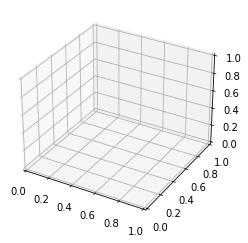

In [ ]:
plot_three_features(df,'x4','x51','x182')

In [ ]:
# Plot a diagram from angle a, b with yields. Remember to use df_origin and df_origin['x198'-'x202'] as input. 
# You can use df_x and df_y, but check and compare the index before use.
def plot_three_features_anydir(df_x,i,j,k,df_y,a,b):
    fig=plt.figure()
    ax=fig.add_subplot(111,projection='3d')
    n=100
    ax.scatter(df_x[i],df_x[j],df_x[k],c=df_y)
    ax.set_xlabel(i)
    ax.set_ylabel(j)
    ax.set_zlabel(k)
    print("A plot of axis:",i, j, ", and ",k)
    # rotate the axes by angles you want
    ax.view_init(a,b)
        
    plt.show()

A plot of axis: x4 x51 , and  x182


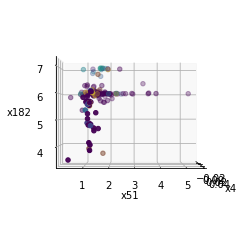

A plot of axis: x4 x51 , and  x182


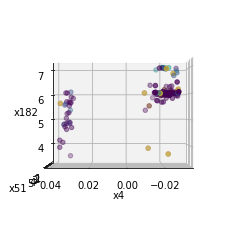

A plot of axis: x4 x51 , and  x182


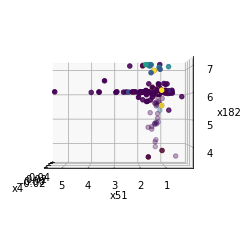

A plot of axis: x4 x51 , and  x182


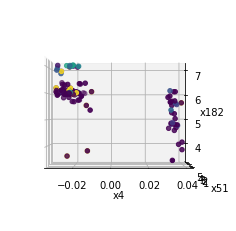

In [ ]:
# Plot 'fraction=12' number of diagrams from different angles, rotating 360/fraction degrees at a time.
blist=[]
a=0
fraction = 4
for i in range(0,fraction):
    blist.append(i*(360/fraction))
for i in blist:
    plot_three_features_anydir(df,'x4','x51','x182',df['x198'],a,i)